In [1]:
import pandas as pd
import numpy as np
import json
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
%matplotlib inline


In [2]:
#Load tree and sequence files
with open('../auspice/flu_seasonal_h3n2_ha_6y_tree.json', 'r') as jsonfile:
    tree_6y = json.load(jsonfile)

with open('../auspice/flu_seasonal_h3n2_ha_6y_sequences.json', 'r') as jsonfile:
    seq_6y = json.load(jsonfile)

#Load genbank file with reference HA sequence
ref_names = {'hemagglutinin':'hemagglutinin','Signal peptide':'SP_ref','HA1 protein':'HA1_ref', 'HA2 protein':'HA2_ref'}
ref_seqs = {}

for seq_record in SeqIO.parse('../h3n2_outgroup.gb', 'genbank'):
    for feature in seq_record.features:
        if feature.type=='CDS':
            ref_seqs[str(ref_names[feature.qualifiers['product'][0]])]= (feature.location.extract(seq_record).seq.translate())

/anaconda2/lib/python2.7/site-packages/Bio/Seq.py:2309: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


In [3]:
#Input desired 0-based HA1 amino acid residue positions, find reference amino acid

positions = [160,194,186,225,219,203,156,138]
position_refaa = []

for pos in positions:
    position_refaa.append((str(pos-1), ref_seqs['HA1_ref'][pos-1]))
    
    
tip_muts = {}

def traverse(branch, seq, pos_list):

    if 'children' not in branch.keys():

        tip_muts[branch['strain']]=[branch['aa_muts']['HA1'], branch['aa_muts']['HA2'], 
                                    branch['aa_muts']['SigPep'],branch['attr']['num_date'], 
                                    branch['attr']['clade_membership']] + [str(seq[str(branch['clade'])]['HA1'][pos]) if pos in seq[str(branch['clade'])]['HA1'] else str(ref_aa) 
                                    for pos, ref_aa in pos_list]

    else:
        for child in branch['children']:
            traverse(child, seq, pos_list)

    
traverse(tree_6y, seq_6y, position_refaa)

#Organize data in a DF
df = pd.DataFrame(tip_muts).T
df.reset_index(inplace=True)
df.columns = ['strain', 'tip_HA1_muts', 'tip_HA2_muts', 'tip_SigPep_muts', 'date', 'clade']+positions
df['passage'] = np.select((df.strain.str.contains('egg'), df.strain.str.contains('cell')), ('egg', 'cell'))
df['source'] = np.select((df.passage=='egg', df.passage=='cell', df.passage=='0'), 
                         (df.strain.str.replace('-egg',''), df.strain.str.replace('-cell',''), df.strain))

#!!!! Must first check all sites of insterest to make sure clades have predeominantly one genotype!!!!
#At each position, find predominant genotype of circulating virus by clade
#Use this to determine whether egg-passaged strains have mutated
#!!!! Must first check all sites of insterest to make sure clades have predeominantly one genotype!!!!

clade_gtype = {}
for p in positions:
    clade_gtype_pos = {}
    for c_name, clade in df[df['passage']=='0'].groupby('clade'):
        clade_gtype_pos[c_name] = str(clade[p].value_counts().nlargest(1))[0]
    clade_gtype[p] = clade_gtype_pos

for p in positions:
    df['circulating'+str(p)] = df['clade'].map(clade_gtype[p])

#make tidy version of df where each mutation gets a row
mut_df = pd.DataFrame(columns=['mutation']+ list(df.columns))

count=0
for i, r in df.iterrows():

    for ha1_mut in r['tip_HA1_muts']:
        mut_df.loc[count]= ['HA1'+str(ha1_mut)] + list(df.loc[i])
        count+=1
        
    for ha2_mut in r['tip_HA2_muts']:
        mut_df.loc[count]= ['HA2'+str(ha2_mut)] + list(df.loc[i])
        count+=1
        
    for sp_mut in r['tip_SigPep_muts']:
        mut_df.loc[count]= ['SP'+str(sp_mut)] + list(df.loc[i])
        count+=1

In [4]:
#Determine whether there sequence has mutated relative to clade background, at each position
for p in positions:
    
    df['mut'+str(p)] = np.select(
    (df[p]==df['circulating'+str(p)], df[p]!=df['circulating'+str(p)]), 
    (False, True))

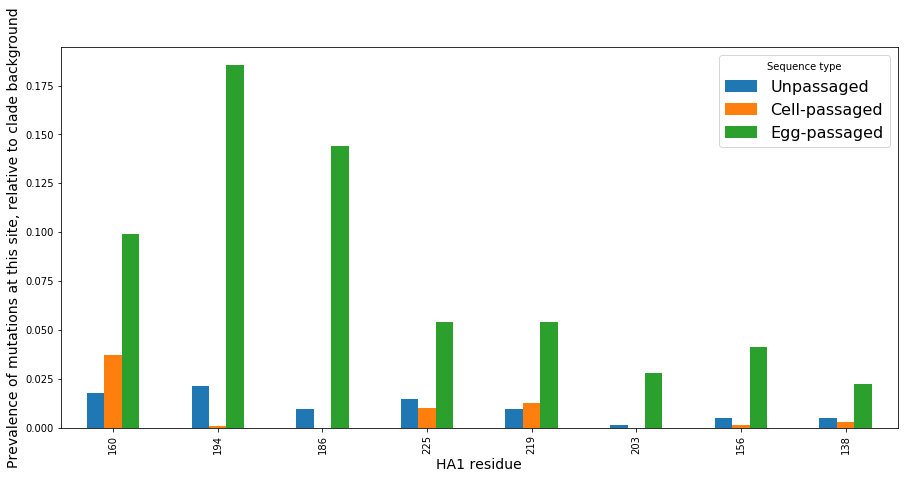

In [5]:
#Make DF with portion of sequences that are mutated compared to clade background, at each site, bt passage type
mut_prev_df = pd.DataFrame()
for p in positions:
    mut_prev= df.groupby('passage')['mut'+str(p)].value_counts(normalize=True)
    mut_prev.name= 'mut_prev'+str(p)
    mut_prev = mut_prev.reset_index().set_index('passage')
    mut_prev_df[p] = mut_prev[mut_prev['mut'+str(p)]==1]['mut_prev'+str(p)]

fig, ax = plt.subplots(figsize=(15,7))
fig = mut_prev_df.T.plot(kind='bar', ax=ax)
plt.xlabel('HA1 residue', size=14)
plt.ylabel('Prevalence of mutations at this site, relative to clade background', size=14)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Unpassaged", "Cell-passaged", "Egg-passaged"], title='Sequence type', loc=1, fontsize=16)

In [6]:
#Determine whether egg mutations happen specifically in certain backgounds
for p in positions:
    print df[df['passage']=='egg'].groupby('clade')['mut'+str(p)].value_counts(normalize=True)

clade       mut160
3b          0         1.000000
3c          0         0.982759
            1         0.017241
3c2.A       0         0.636364
            1         0.363636
3c3         0         1.000000
3c3.A       0         1.000000
3c3.B       0         1.000000
A1          0         0.652174
            1         0.347826
A1a         0         0.800000
            1         0.200000
A1b         0         0.666667
            1         0.333333
A1b/135K    0         0.600000
            1         0.400000
A1b/135N    0         0.666667
            1         0.333333
A2          0         0.777778
            1         0.222222
A2/re       0         0.684211
            1         0.315789
A3          0         0.625000
            1         0.375000
A4          1         1.000000
unassigned  0         1.000000
Name: mut160, dtype: float64
clade       mut194
3b          0         0.972222
            1         0.027778
3c          0         0.810345
            1         0.189655
3c2

In [7]:
df[df['passage']=='egg'].groupby('mut219')['mut156'].value_counts()

mut219  mut156
0       0         488
        1          17
1       0          24
        1           5
Name: mut156, dtype: int64

In [8]:
df[df['passage']=='egg'].groupby(['mut194', 'mut186'])['mut160'].value_counts()

mut194  mut186  mut160
0       0       0         359
        1       0          69
                1           7
1       0       0          52
                1          46
        1       0           1
Name: mut160, dtype: int64

In [9]:
egg_df = df[df['passage']=='egg']

# egg_df[egg_df['circulating160']=='T'].groupby(['mut194','mut186'])[160].value_counts()

egg_df[egg_df['circulating160']=='K'].groupby(['mut194','mut186'])[160].value_counts()

mut194  mut186  160
0       0       K      269
        1       K       67
1       0       K       48
                R        1
        1       K        1
Name: 160, dtype: int64

In [10]:
egg_df.groupby(['clade','circulating160'])['mut186'].value_counts(normalize=True)

clade       circulating160  mut186
3b          K               0         0.888889
                            1         0.111111
3c          K               0         0.672414
                            1         0.327586
3c2.A       T               0         0.963636
                            1         0.036364
3c3         K               0         0.813953
                            1         0.186047
3c3.A       K               0         0.545455
                            1         0.454545
3c3.B       K               0         0.571429
                            1         0.428571
A1          T               0         0.869565
                            1         0.130435
A1a         T               0         0.900000
                            1         0.100000
A1b         T               0         0.916667
                            1         0.083333
A1b/135K    T               0         0.800000
                            1         0.200000
A1b/135N    T            

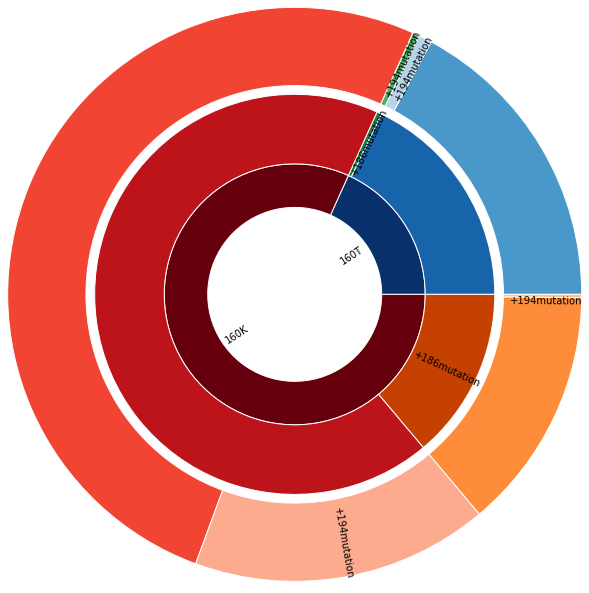

In [11]:
#Make nested donut plot

t160=(egg_df[160]=='T')
k160=(egg_df[160]=='K')
s186=(egg_df[186]=='S')
nots186=(egg_df[186]!='S')
l194=(egg_df[194]=='L')
notl194=(egg_df[194]!='L')

sector_names = ['160T', '160K']
sector_sizes = [len(egg_df[t160]), len(egg_df[k160])]
sub1_names = ['', '+186mutation', '', '+186mutation']
sub1_sizes =  [len(egg_df[t160 & s186]), len(egg_df[t160 & nots186]),
                    len(egg_df[k160 & s186]), len(egg_df[k160 & nots186])]
# sub2_names = ['160T+186S+194L', '160T+186S+194mutation', '160T+186mutation+194L', '160T+186mutation+194mutation',  
#               '160K+186S+194L', '160K+186S+194mutation', '160K+186mutation+194L', '160K+186mutation+194mutation',]
sub2_names = ['', '+194mutation', '', '+194mutation',  
              '', '+194mutation', '', '+194mutation',]
sub2_sizes =  [len(egg_df[t160 & s186 & l194]), len(egg_df[t160 & s186 & notl194]), len(egg_df[t160 & nots186 & l194]), len(egg_df[t160 & nots186 & notl194]),
                    len(egg_df[k160 & s186 & l194]), len(egg_df[k160 & s186 & notl194]), len(egg_df[k160 & nots186 & l194]), len(egg_df[k160 & nots186 & notl194])]

t, ts, k, ks =[plt.cm.Greens, plt.cm.Blues, plt.cm.Oranges, plt.cm.Reds]

#outside ring:
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(sector_sizes, radius=1.5, labels=sector_names, labeldistance=0.4, rotatelabels=True, colors=[ts(1.0), ks(1.0)] )
plt.setp( mypie, width=0.5, edgecolor='white')

#second ring:
mypie2, _ = ax.pie(sub1_sizes, radius=2.3, labels=sub1_names, labeldistance=0.65,rotatelabels=True, 
#                    explode= (0,0.1,0,0.1),
                   colors=[ts(0.8), t(0.8), ks(0.8), k(0.8)])
plt.setp(mypie2, width=0.8, edgecolor='white')


#third ring:
mypie3, _ = ax.pie(sub2_sizes, radius=3.3, labels=sub2_names, labeldistance=0.75, rotatelabels=True, 
#                    explode= (0,0.1,0,0.1,0,0.1,0,0.1), 
                   colors=[ts(0.6), ts(0.3), t(0.6), t(0.3), ks(0.6), ks(0.3), k(0.5), k(0.3)])
plt.setp(mypie3, width=0.9, edgecolor='white')


# plt.legend(loc=(1.5,2.0))
plt.margins(0,0)


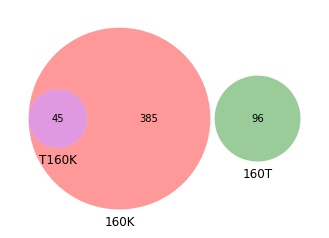

In [12]:
#Venn diagram of mutation overlap
v1=len(egg_df[egg_df[160]=='K'])-len(egg_df[(egg_df[160]=='K')&(egg_df['circulating160']=='T')])
v2=len(egg_df[egg_df[160]=='T'])
v3=0
v4=0
v5=len(egg_df[(egg_df[160]=='K')&(egg_df['circulating160']=='T')])
v6=0
v7=0

v = venn3(subsets=(v1,v2,v3,v4,v5,v6,v7), set_labels=('160K', '160T', 'T160K'))


In [57]:
# egg_df[egg_df[160]=='T'].groupby([194,186,156])[219].value_counts()

# egg_df[(egg_df[160]=='K')&(egg_df['circulating160']=='T')].groupby([194,186,156])[219].value_counts()

egg_df[(egg_df[160]=='K')&(egg_df['circulating160']!='T')].groupby([194,186,156])[219].value_counts()



194  186  156  219
L    D    K    S        1
     E    R    S        1
     I    K    S        1
     R    K    S        5
     S    K    S      265
          Q    S        1
          R    S        2
               F        1
     V    K    S       23
               F       12
               Y        9
          Q    S        7
               F        2
               Y        1
          R    S        4
               F        1
M    S    K    S        1
P    A    K    S        1
     S    K    S       47
Name: 219, dtype: int64

In [89]:
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout

layout = Layout(width="1000", height="600")
links = [
    #160T
    {'source': '160T passaged in eggs', 'target': '160T', 'value': 96, 'color': '#ff0000'},
    {'source': '160T', 'target': 'T-194L', 'value': 92, 'color': '#ff0000'},
    {'source': '160T', 'target': 'T-194mutation', 'value': 4,  'color': '#ff6666'},
    {'source': 'T-194L', 'target': 'T-L-186S', 'value': 90,  'color': '#ff0000'},
    {'source': 'T-194L', 'target': 'T-L-186mutation', 'value': 2,  'color': '#ff6666'},
    {'source': 'T-194mutation', 'target': 'T-X-186S', 'value': 4,  'color': '#ff6666'},
    {'source': 'T-X-186S', 'target': 'T-X-S-156K', 'value': 4,  'color': '#ff6666'},
    {'source': 'T-X-S-156K', 'target': 'T-X-S-K-219S', 'value': 4,  'color': '#ff6666'},
    {'source': 'T-L-186S', 'target': 'T-L-S-156K', 'value': 89,  'color': '#ff0000'},
    {'source': 'T-L-S-156K', 'target': 'T-L-S-K-S', 'value': 89,  'color': '#ff0000'},
    {'source': 'T-L-186S', 'target': 'T-L-S-156mutation', 'value': 1,  'color': '#ff6666'},
    {'source': 'T-L-S-156mutation', 'target': 'T-L-S-X-219S', 'value': 1,  'color': '#ff6666'},
    {'source': 'T-L-186mutation', 'target': 'T-L-X-156K', 'value': 2,  'color': '#ff6666'},
    {'source': 'T-L-X-156K', 'target': 'T-L-X-K-219S', 'value': 2,  'color': '#ff6666'},
    
    #T160K
    {'source': '160T passaged in eggs', 'target': 'T160K', 'value': 45, 'color': '#ff6666'},
    {'source': 'T160K', 'target': 'X-194L', 'value': 5, 'color': '#ff6666'},
    {'source': 'T160K', 'target': 'X-194mutation', 'value': 40, 'color': '#ff9999'},
    {'source': 'X-194L', 'target': 'X-L-186mutation', 'value': 5, 'color': '#ff9999'},
    {'source': 'X-194mutation', 'target': 'X-X-186S', 'value': 40, 'color': '#ff9999'},
    {'source': 'X-L-186mutation', 'target': 'X-L-X-156K', 'value': 4, 'color': '#ff9999'},
    {'source': 'X-L-186mutation', 'target': 'X-L-X-156mutation', 'value': 1, 'color': '#ffcccc'},
    {'source': 'X-X-186S', 'target': 'X-X-S-156K', 'value': 40, 'color': '#ff9999'},
    {'source': 'X-L-X-156K', 'target': 'X-L-X-K-219S', 'value': 2, 'color': '#ff9999'},
    {'source': 'X-L-X-156K', 'target': 'X-L-X-K-219mutation', 'value': 2, 'color': '#ffcccc'},
    {'source': 'X-L-X-156mutation', 'target': 'X-L-X-X-219S', 'value': 1, 'color': '#ffcccc'},
    {'source': 'X-X-S-156K', 'target': 'X-X-S-K-219S', 'value': 40, 'color': '#ff9999'},
    
    #160K
    {'source': '160K passaged in eggs', 'target': '160K', 'value': 385, 'color': '#0000ff'},
    {'source': '160K', 'target': 'K-194L', 'value': 336, 'color': '#0000ff'},
    {'source': '160K', 'target': 'K-194mutation', 'value': 49, 'color': '#6666ff'},
    {'source': 'K-194L', 'target': 'K-L-186S', 'value': 269, 'color': '#0000ff'},
    {'source': 'K-194L', 'target': 'K-L-186mutation', 'value': 67, 'color': '#6666ff'},
    {'source': 'K-194mutation', 'target': 'K-X-186S', 'value': 48, 'color': '#6666ff'},
    {'source': 'K-194mutation', 'target': 'K-X-186mutation', 'value': 1, 'color': '#9999ff'},
    {'source': 'K-L-186S', 'target': 'K-L-S-156K', 'value': 265, 'color': '#0000ff'},
    {'source': 'K-L-186S', 'target': 'K-L-S-156mutation', 'value': 4, 'color': '#6666ff'},
    {'source': 'K-L-186mutation', 'target': 'K-L-X-156K', 'value': 51, 'color': '#6666ff'},
    {'source': 'K-L-186mutation', 'target': 'K-L-X-156mutation', 'value': 16, 'color': '#9999ff'},
    {'source': 'K-X-186S', 'target': 'K-X-S-156K', 'value': 48, 'color': '#6666ff'},
    {'source': 'K-X-186mutation', 'target': 'K-X-X-156K', 'value': 1, 'color': '#9999ff'},
    {'source': 'K-L-S-156K', 'target': 'K-L-S-K-219S', 'value': 265, 'color': '#0000ff'},
    {'source': 'K-L-S-156mutation', 'target': 'K-L-S-X-219S', 'value': 3, 'color': '#6666ff'},
    {'source': 'K-L-S-156mutation', 'target': 'K-L-S-X-219mutation', 'value': 1, 'color': '#9999ff'},
    {'source': 'K-L-X-156K', 'target': 'K-L-X-K-219S', 'value': 30, 'color': '#6666ff'},
    {'source': 'K-L-X-156K', 'target': 'K-L-X-K-219mutation', 'value': 21, 'color': '#9999ff'},
    {'source': 'K-L-X-156mutation', 'target': 'K-L-X-X-219S', 'value': 12, 'color': '#9999ff'},
    {'source': 'K-L-X-156mutation', 'target': 'K-L-X-X-219mutation', 'value': 4, 'color': '#ccccff'},
    
    
    
    {'source': 'K-X-S-156K', 'target': 'K-X-S-K-219S', 'value': 48, 'color': '#6666ff'},
    {'source': 'K-X-X-156K', 'target': 'K-X-X-K-219S', 'value': 1, 'color': '#9999ff'},
    
]



sankey= SankeyWidget(links=links, layout=layout, margins=dict(top=10, bottom=0, left=150, right=150))
sankey

A Jupyter Widget